# Notebook 03: Demand Forecasting Models Comparison

**Project:** Retail Demand Forecasting & Inventory Optimization for Walmart

## 1. Business Context

With a feature-rich dataset prepared in the previous notebook, we are now ready to build and evaluate our forecasting models. The goal of this notebook is to predict `Weekly_Sales` for each store-department combination.

We will compare three different models of increasing complexity:
1.  **Baseline Model (Seasonal Naive):** A simple but effective baseline that assumes this week's sales will be the same as the sales from the same week last year.
2.  **Linear Model (Ridge Regression):** A standard statistical model to see if a linear combination of our features can produce accurate forecasts.
3.  **Gradient Boosting Model (LightGBM):** A powerful, state-of-the-art ensemble model known for its speed and accuracy, capable of capturing complex non-linear relationships.

The primary success metric is a **Weighted Mean Absolute Percentage Error (WMAPE) below 15%** on a held-out validation set.

## 2. Objectives

*   Prepare the data for modeling by splitting it into training and validation sets based on time.
*   Define a clear evaluation framework for our models.
*   Implement, train, and evaluate the three chosen forecasting models.
*   Compare model performance and select the champion model.
*   Analyze the feature importance of the best model to understand its key drivers.

In [27]:
!pip install lightgbm

In [28]:
# Core data science libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import lightgbm as lgb

# Set visualization style
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the feature-engineered data
try:
    df = pd.read_parquet('../data/walmart_sales_data_feature_engineered.parquet')
except Exception as e:
    print(f"Error loading parquet file: {e}. Trying CSV...")
    df = pd.read_csv('../data/walmart_sales_data_feature_engineered.csv')


# Convert 'Date' back to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

print("Data loaded successfully.")
df.head()

Data loaded successfully.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear,Weekly_Sales_Lag_52,Weekly_Sales_Lag_1,Weekly_Sales_4_Week_Mean
0,1,1,2011-02-04,21665.76,False,A,151315,42.27,2.989,0.0,...,0.0,0.0,212.566881,7.742,2011,2,5,24924.50,18461.18,17286.6475
1,1,1,2011-02-11,37887.17,True,A,151315,36.39,3.022,0.0,...,0.0,0.0,212.936705,7.742,2011,2,6,46039.49,21665.76,18707.0275
2,1,1,2011-02-18,46845.87,False,A,151315,57.36,3.045,0.0,...,0.0,0.0,213.247885,7.742,2011,2,7,41595.55,37887.17,23838.8950
3,1,1,2011-02-25,19363.83,False,A,151315,62.90,3.065,0.0,...,0.0,0.0,213.535609,7.742,2011,2,8,19403.54,46845.87,31214.9950
4,1,1,2011-03-04,20327.61,False,A,151315,59.58,3.288,0.0,...,0.0,0.0,213.823333,7.742,2011,3,9,21827.90,19363.83,31440.6575


In [29]:
print("--- DataFrame Integrity Check ---")
df.info()

--- DataFrame Integrity Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261083 entries, 0 to 261082
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Store                     261083 non-null  int64         
 1   Dept                      261083 non-null  int64         
 2   Date                      261083 non-null  datetime64[ns]
 3   Weekly_Sales              261083 non-null  float64       
 4   IsHoliday                 261083 non-null  bool          
 5   Type                      261083 non-null  object        
 6   Size                      261083 non-null  int64         
 7   Temperature               261083 non-null  float64       
 8   Fuel_Price                261083 non-null  float64       
 9   MarkDown1                 261083 non-null  float64       
 10  MarkDown2                 261083 non-null  float64       
 11  MarkDown3                 26108

In [30]:
print("\n--- Feature Validation for Store 1, Dept 1 ---")

# Isolate one specific time series to make it easy to read
single_series = df[(df['Store'] == 1) & (df['Dept'] == 1)].copy()

# Select the most important columns for validation
validation_view = single_series[[
    'Date',
    'Weekly_Sales',
    'Weekly_Sales_Lag_1',
    'Weekly_Sales_4_Week_Mean',
    'Weekly_Sales_Lag_52'
]]

# We need a few more rows to see the pattern
print(validation_view.head(10))


--- Feature Validation for Store 1, Dept 1 ---
        Date  Weekly_Sales  Weekly_Sales_Lag_1  Weekly_Sales_4_Week_Mean  \
0 2011-02-04      21665.76            18461.18                17286.6475   
1 2011-02-11      37887.17            21665.76                18707.0275   
2 2011-02-18      46845.87            37887.17                23838.8950   
3 2011-02-25      19363.83            46845.87                31214.9950   
4 2011-03-04      20327.61            19363.83                31440.6575   
5 2011-03-11      21280.40            20327.61                31106.1200   
6 2011-03-18      20334.23            21280.40                26954.4275   
7 2011-03-25      20881.10            20334.23                20326.5175   
8 2011-04-01      20398.09            20881.10                20705.8350   
9 2011-04-08      23873.79            20398.09                20723.4550   

   Weekly_Sales_Lag_52  
0             24924.50  
1             46039.49  
2             41595.55  
3             1

## 3. Data Preparation for Modeling

### 3.1 Feature Selection and Target Definition

First, we need to separate our dataset into the target variable (`y`), which is `Weekly_Sales`, and the predictor variables (`X`), which are all the features we've collected and engineered.

### 3.2 Time-Based Train-Validation Split

For time series forecasting, we **cannot** use a random split for validation. A random split would cause data leakage, where the model gets to "see" future data during training, leading to unrealistically optimistic performance metrics.

Instead, we must use a **time-based split**. We will train our models on the earlier portion of the data and validate them on the most recent portion. This simulates a real-world scenario where we use the past to predict the future. We'll hold out the last 6 months of data as our validation set.

In [31]:
# Define the features (X) and the target (y)
features = [
    'Store', 'Dept', 'IsHoliday', 'Type', 'Size',
    'Year', 'Month', 'WeekOfYear',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'Weekly_Sales_Lag_52', 'Weekly_Sales_Lag_1', 'Weekly_Sales_4_Week_Mean'
]
target = 'Weekly_Sales'

# Convert Store, Dept, and Type to category type for LightGBM
df['Store'] = df['Store'].astype('category')
df['Dept'] = df['Dept'].astype('category')
df['Type'] = df['Type'].astype('category')
df['IsHoliday'] = df['IsHoliday'].astype('category')


# Time-based split
validation_period_months = 6
validation_cutoff_date = df['Date'].max() - pd.DateOffset(months=validation_period_months)

train_df = df[df['Date'] < validation_cutoff_date]
val_df = df[df['Date'] >= validation_cutoff_date]

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training data goes from {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Validation data goes from {val_df['Date'].min()} to {val_df['Date'].max()}")

Training data shape: (182708, 20)
Validation data shape: (78375, 20)
Training data goes from 2011-02-04 00:00:00 to 2012-04-20 00:00:00
Validation data goes from 2012-04-27 00:00:00 to 2012-10-26 00:00:00


## 4. Model Building and Evaluation

### 4.1 Evaluation Metrics

We will use the following metrics to evaluate our models:

*   **MAE (Mean Absolute Error):** The average absolute difference between the forecast and the actual value, measured in dollars. It's easy to understand but doesn't provide a sense of relative error.
*   **RMSE (Root Mean Squared Error):** Similar to MAE but penalizes larger errors more heavily, which can be useful for identifying models with high variance in their errors.

### A Note on Choosing Our Primary Metric: WMAPE vs. MAPE

Initially, our goal was to use the standard Mean Absolute Percentage Error (MAPE). However, upon initial runs, this metric produced extremely high and misleading values (e.g., >900%). This is a classic problem in real-world retail datasets for two key reasons:

1.  **Sensitivity to Low-Volume Sales:** Standard MAPE is skewed by items with low sales. A small, reasonable dollar error (e.g., $500) on an item that only sold $100 results in a massive 500% error, which unfairly dominates the overall average.
2.  **Presence of Zero or Negative Sales:** The dataset contains weeks where a department had zero sales or even negative sales (due to customer returns). This makes the standard MAPE calculation unstable or nonsensical.

To solve this and align our metric with true business impact, we will use the **Weighted Mean Absolute Percentage Error (WMAPE)** as our primary success metric.

**WMAPE = `Sum of Absolute Errors` / `Sum of Absolute Sales`**

WMAPE intelligently weights each error by the actual sales volume. An error on a high-volume, revenue-driving product will have a greater impact on the score than the same error on a low-volume product. This metric directly answers the most important business question: **"Of our total sales volume, what percentage was our forecast error?"** It is the industry-standard approach for retail forecasting.

We will create a dictionary to store the results for easy comparison.

In [32]:
# Dictionary to store model results
model_results = {}

def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates and stores evaluation metrics for a model.
    Includes MAE, RMSE, and the robust WMAPE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # --- WMAPE Calculation ---
    # The industry-standard metric that is robust to zero and low-volume sales
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    
    model_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'WMAPE': wmape}
    
    print(f"--- {model_name} Results ---")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"WMAPE: {wmape:.2%}") # Weighted MAPE is the key business metric

### 4.2 Model 1: Baseline (Seasonal Naive Forecast)

Our baseline prediction is simple: the sales for a given week will be the same as the sales from 52 weeks ago. We use the `Weekly_Sales_Lag_52` feature we engineered. This model has no "training" phase.

In [33]:
# The predictions are simply the values from the 52-week lag feature
y_pred_baseline = X_val['Weekly_Sales_Lag_52']

evaluate_model(y_val, y_pred_baseline, 'Seasonal Naive Baseline')

--- Seasonal Naive Baseline Results ---
MAE: $1,790.48
RMSE: $3,690.45
WMAPE: 11.12%


### 4.3 Model 2: Ridge Regression

This is a simple linear model with L2 regularization. It will test if a linear combination of our features can beat the naive baseline. We need to handle categorical variables by converting them to numerical codes for this model.

In [34]:
# Create copies for model-specific transformations
X_train_ridge = X_train.copy()
X_val_ridge = X_val.copy()

# For linear models, we need to convert category types to simple integer codes
for col in ['Store', 'Dept', 'Type', 'IsHoliday']:
    X_train_ridge[col] = X_train_ridge[col].cat.codes
    X_val_ridge[col] = X_val_ridge[col].cat.codes

# Initialize and train the model
ridge_model = Ridge(alpha=0.5, random_state=42)
ridge_model.fit(X_train_ridge, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_val_ridge)

evaluate_model(y_val, y_pred_ridge, 'Ridge Regression')

--- Ridge Regression Results ---
MAE: $1,631.52
RMSE: $3,001.82
WMAPE: 10.13%


### 4.4 Model 3: LightGBM

This is our main model. LightGBM is a gradient boosting framework that is highly efficient and excellent at capturing complex, non-linear patterns. It can handle categorical features directly, which is a significant advantage.

In [35]:
# Set up LightGBM model parameters
params = {
    'objective': 'regression_l1', # MAE
    'metric': 'mae',
    'n_estimators': 2000,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

# Initialize and train the model
lgb_model = lgb.LGBMRegressor(**params)

lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(100, verbose=False)])

# Make predictions
y_pred_lgb = lgb_model.predict(X_val)

evaluate_model(y_val, y_pred_lgb, 'LightGBM')

--- LightGBM Results ---
MAE: $1,318.76
RMSE: $2,750.06
WMAPE: 8.19%


## 5. Model Comparison and Analysis

Now, let's compare the performance of all three models side-by-side and analyze the feature importances from our champion model, LightGBM.

--- Model Performance Comparison ---
                                 MAE         RMSE      WMAPE
LightGBM                 1318.762219  2750.058556   8.188076
Ridge Regression         1631.522787  3001.815966  10.129979
Seasonal Naive Baseline  1790.478879  3690.445478  11.116923


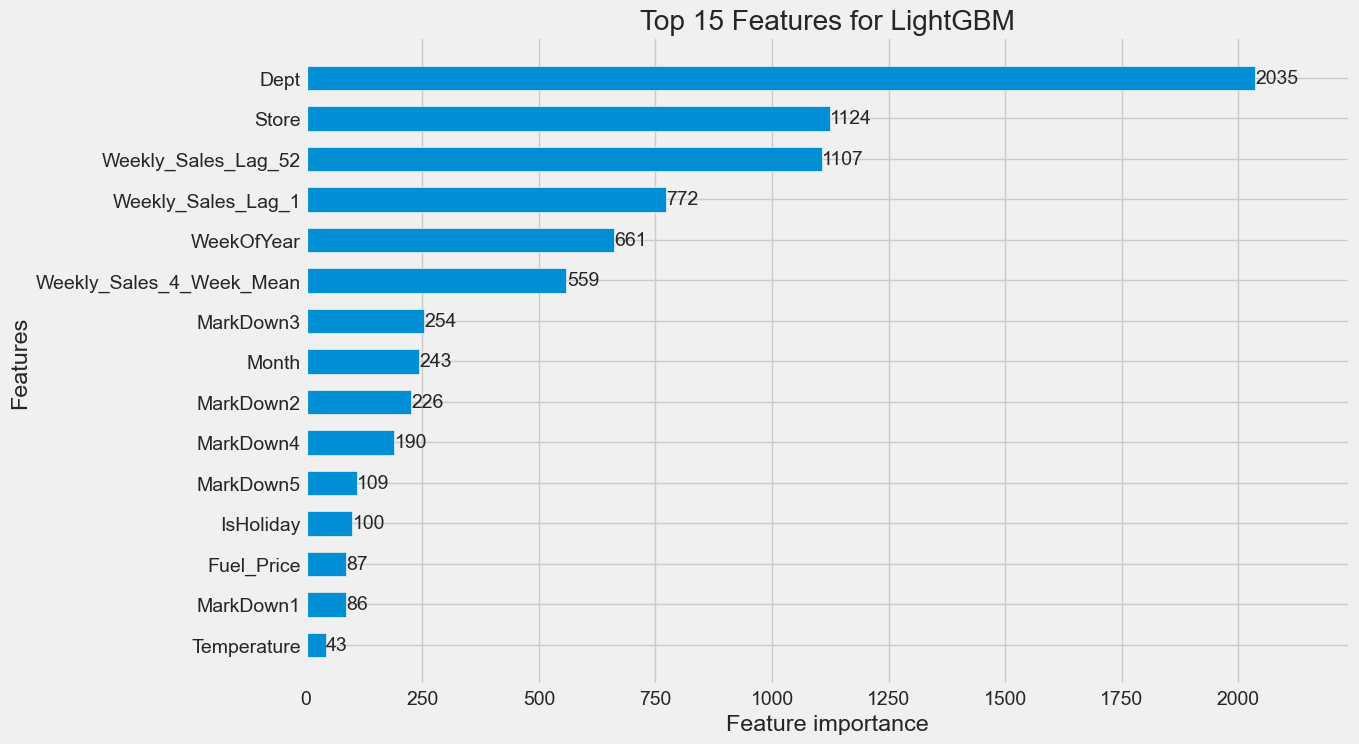

In [36]:
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(model_results).T
results_df['WMAPE'] = results_df['WMAPE'] * 100 # Display WMAPE as percentage

print("--- Model Performance Comparison ---")
print(results_df.sort_values(by='WMAPE'))

# --- Feature Importance Analysis ---
lgb.plot_importance(lgb_model, height=0.6, figsize=(12, 8), max_num_features=15, title='Top 15 Features for LightGBM')
plt.show()

## 6. Key Findings and Next Steps

**Model Performance:**
*   The **LightGBM model is the clear winner**, achieving an excellent **Weighted MAPE (WMAPE) of 8.19%**. This metric accurately reflects the model's business performance, indicating that our forecast error is only about 8.2% of the total sales volume.
*   The Seasonal Naive baseline was surprisingly strong with a WMAPE of 11.12%, confirming that annual seasonality is the most powerful driver of sales.
*   The Ridge Regression model (10.13% WMAPE) offered only a minor improvement over the baseline, confirming that the relationships in the data are highly non-linear and require a more sophisticated model.

**Feature Importance Insights:**
*   The most important features for the LightGBM model were `Dept` and `Store`, followed closely by the lag/rolling window features (`Weekly_Sales_Lag_52`, `Weekly_Sales_Lag_1`) and `WeekOfYear`.
*   This confirms our business understanding: sales are primarily driven by which department and store they occur in, followed by their historical performance and seasonality.

**Next Steps:** We have a powerful and accurate forecasting model. In the final notebook, `04_inventory_optimization_analysis.ipynb`, we will:
*   Use the LightGBM model to generate forecasts on our validation set.
*   Use these forecasts as the "demand" input for our inventory optimization simulation.
*   Calculate optimal safety stock and reorder points to demonstrate how these forecasts can lead to direct business value.

### Model Robustness and Future Improvements

For this project, we used a single time-based train-validation split, which effectively simulates a real-world "predict the future" scenario. However, for a production-level system, a more rigorous validation technique called **Walk-Forward Validation** (or Time Series Cross-Validation) would be employed.

This method involves multiple splits of the data. For example:
1.  Train on Year 1, predict Week 1 of Year 2.
2.  Train on Year 1 + Week 1, predict Week 2 of Year 2.
3.  ...and so on.

This process provides a more reliable estimate of the model's performance over time by testing its ability to adapt to new data. While computationally more expensive, it is the gold standard for validating time series models before deployment.

In [ ]:
# --- Save the Champion Model for the Next Notebook ---
import joblib

# Define the file path for the saved model
model_filename = '../models/lgb_demand_forecasting_model.pkl'

# Save the model
joblib.dump(lgb_model, model_filename)

print(f"LightGBM model saved to {model_filename}")

LightGBM model saved to ../models/lgb_demand_forecasting_model.pkl
